In [3]:
import sys
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/gdrive')
    %cd gdrive/MyDrive/
    ! git clone https://github.com/AfoninAndrei/OPT-ML.git
    %cd OPT-ML    
    sys.path.append('/content/gdrive/MyDrive/LastFM/src')
else:
    sys.path.append('src')

In [31]:
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns 

from training import *
from meta_optimizer import *
from optimizee import *
from loss import *

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

sns.set(color_codes=True)
sns.set_style("white")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Compute number of parameters

In [15]:
num_lstm_params = sum(p.numel() for p in Optimizer_LSTM().parameters())
num_hnn_params = sum(p.numel() for p in Optimizer_HNN().parameters())
print('Number of LSTM parameters: {}\nNumber HNN parameters: {}'.format(num_lstm_params, num_hnn_params))

Number of LSTM parameters: 5221
Number HNN parameters: 17


In [17]:
num_lstm_params = sum(p.numel() for p in Optimizer_LSTM(preproc=True).parameters())
num_hnn_params = sum(p.numel() for p in Optimizer_HNN(preproc=True).parameters())
print('Number of LSTM parameters: {}\nNumber HNN parameters: {}'.format(num_lstm_params, num_hnn_params))

Number of LSTM parameters: 5301
Number HNN parameters: 51


# Quadratic loss


In [40]:
best_loss, best_lr, best_out_mul = find_best_parameters_HNN(QuadraticLoss, QuadOptimizee)
print(best_loss, best_lr, best_out_mul)

0.53969946 0.01 0.001


In [13]:
loss_HNN, quad_optimizer_HNN = fit(QuadraticLoss, QuadOptimizee, 'HNN', unroll=15, optim_it=100, lr=0.01,\
                                       n_tests=50, n_epochs=100, out_mul=0.001)

In [14]:
loss_LSTM, quad_optimizer_LSTM = fit(QuadraticLoss, QuadOptimizee, 'LSTM', unroll=20, optim_it=100, lr=0.003,\
                                          n_tests=10, n_epochs=100)

In [15]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

Best loss of LSTM =  0.35714084
Best loss of HNN =  0.48392123


In [22]:
fit_data = np.zeros((100, 100, 6))

opt = w(Optimizer_LSTM())
opt.load_state_dict(quad_optimizer_LSTM)
fit_data[:, :, 0] = np.array([one_step_fit_LSTM(opt, None, QuadraticLoss, QuadOptimizee, \
                                                1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN())
opt.load_state_dict(quad_optimizer_HNN)
fit_data[:, :, 1] = np.array([one_step_fit_HNN(opt, None, QuadraticLoss, QuadOptimizee, \
                                               1, 100, 100, out_mul=0.001, should_train=False) for _ in range(100)])
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    fit_data[:, :, 2 + i] = np.array(fit_normal(QuadraticLoss, QuadOptimizeeNormal, opt, lr=lr, **extra_kwargs))

In [45]:
np.save('quad_fit_data', fit_data)

In [47]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data, axis=0)[-1, i]))

LSTM: 0.25
HNN: 0.29
ADAM: 0.41
RMSprop: 0.76
SGD: 0.33
NAG: 0.45


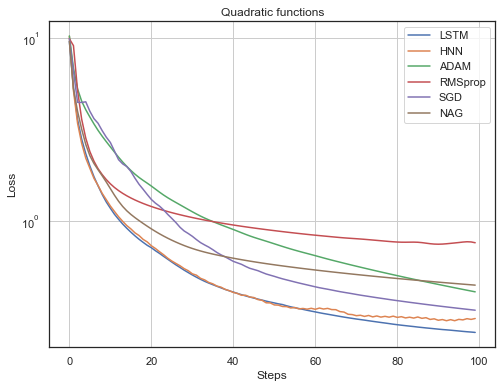

In [48]:
plt.figure(figsize=(8,6))
for i, opt in enumerate(names):
    plt.plot(np.mean(fit_data[:,:,i], axis=0), label=opt)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Quadratic functions')
plt.legend()
plt.grid()
plt.savefig('quad.pdf')
plt.show()

# MNIST

In [ ]:
best_loss, best_lr, best_out_mul=find_best_parameters_HNN(MNISTLoss, MNISTNet, preproc=True)
print(best_loss, best_lr, best_out_mul)

In [36]:
loss_HNN, MNIST_optimizer_HNN = fit(MNISTLoss, MNISTNet, 'HNN', unroll=15, optim_it=100, lr=0.01,\
                                        out_mul=0.001, preproc=True, n_tests=10, n_epochs=50)

In [ ]:
loss_LSTM, MNIST_optimizer_LSTM = fit(MNISTLoss, MNISTNet, 'LSTM', unroll=20, optim_it=100, lr=0.01,\
                                           out_mul=0.1, preproc=True, n_tests=10, n_epochs=50)

In [ ]:
print('Best loss of LSTM = ', loss_LSTM)
print('Best loss of HNN = ', loss_HNN)

In [ ]:
fit_data1 = np.zeros((100, 100, 6))

opt = w(Optimizer_LSTM(preproc=True))
opt.load_state_dict(MNIST_optimizer_LSTM)
fit_data1[:, :, 0] = np.array([one_step_fit_LSTM(opt, None, MNISTLoss, MNISTNet, 1, 100, 200, out_mul=1.0, should_train=False) for _ in range(100)])
opt = w(Optimizer_HNN(preproc=True))
opt.load_state_dict(MNIST_optimizer_HNN)
fit_data1[:, :, 1] = np.array([one_step_fit_HNN(opt, None, MNISTLoss, MNISTNet, 1, 100, 200, out_mul=0.001, should_train=False) for _ in range(100)])
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    fit_data1[:, :, 2 + i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, **extra_kwargs))

In [ ]:
np.save('mnist_fit_data_relu', fit_data1)

In [ ]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data1, axis=0)[-1, i]))

In [ ]:
plt.figure(figsize=(8,6))
for i, opt in enumerate(names):
    plt.plot(np.mean(fit_data[:,:,i], axis=0), label=opt)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('MNIST')
plt.legend()
plt.yscale('log')
plt.grid()
plt.savefig('mnist.pdf')
plt.show()

In [34]:
names = ['LSTM', 'HNN', 'ADAM', 'RMSprop', 'SGD', 'NAG']
for i, name in enumerate(names):
    print('{}: {:.2f}'.format(name, np.mean(fit_data1, axis=0)[-1, i]))

LSTM: 1.85
HNN: 0.38
ADAM: 0.34
RMSprop: 0.37
SGD: 0.36
NAG: 0.32


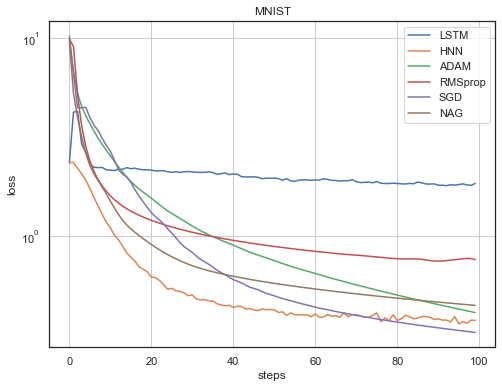

In [39]:
plt.figure(figsize=(8,6))
plt.plot(np.mean(fit_data1[:,:,0], axis=0), label='LSTM')
plt.plot(np.mean(fit_data1[:,:,1], axis=0), label='HNN')
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']
for i, opt in enumerate(OPT_NAMES):
    plt.plot(np.mean(fit_data[:,:,2+i], axis=0), label=opt)
    
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.legend()
plt.yscale('log')
plt.grid()
plt.savefig('mnist.pdf')
plt.show()